# INFORMAÇÕES IMPORTANTES:

## Dependências

## Especificações da Pesquisa

- Horizonte de previsão: 30 min, 1 hora, 3 horas


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Utilização de rede neural recorrente LSTM para previsões intradiárias do mercado de ações. 

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np


#-----------------------------------------------------------
#Lê os dados do arquivo CSV.
#-----------------------------------------------------------
data = pd.read_csv('Inteligencia_Artificial/Trabalho de Conclusão de Curso/Base de Dados/2021/BBDC4_30m_2021.csv') 
data.head()
#print(df)
#df.info()

,time,open,high,low,close,Volume,Volume MA
0,2021-01-04T10:00:00-03:00,21.814317,21.814317,21.505287,21.521135,1880012,1384668.55
1,2021-01-04T10:30:00-03:00,21.529059,21.576602,21.441896,21.497363,1532703,1368010.00
2,2021-01-04T11:00:00-03:00,21.505287,21.552830,21.473592,21.481516,877715,1345874.15
3,2021-01-04T11:30:00-03:00,21.497363,21.521135,21.132867,21.188334,5465393,1548509.50
4,2021-01-04T12:00:00-03:00,21.188334,21.227953,21.085324,21.124943,4150374,1694177.35


In [2]:
#-----------------------------------------------------------
#Escolhe a coluna de série temporal única de interesse.
#-----------------------------------------------------------
symbol = "close"

data = pd.DataFrame(data[symbol])
data.head()


,close
0,21.521135
1,21.497363
2,21.481516
3,21.188334
4,21.124943


In [3]:
#-----------------------------------------------------------
#Renomeia a única coluna para price
#-----------------------------------------------------------

data.rename(columns={symbol: 'price'}, inplace=True)

data.head()

,price
0,21.521135
1,21.497363
2,21.481516
3,21.188334
4,21.124943


In [4]:
#-----------------------------------------------------------
# Calcula o log de retorno e define a direção como uma coluna binária.
#-----------------------------------------------------------

#Log Retorno
data['return'] = np.log(data['price']/data['price'].shift(1))

temp = pd.DataFrame({})

#Coluna binária
temp['direction'] = np.where(data['return'] > 0, 1, 0)
#data.head()

display(temp)

,direction
0,0
1,0
2,0
3,0
4,0
...,...
3933,1
3934,0
3935,0
3936,0


In [5]:
#Para a previsão do mercado de ações, é crucial encontrar dependências de tempo bem definidas
lags = 4

cols = []
#-----------------------------------------------------------
# Cria os Lagged Data
#-----------------------------------------------------------
for lag in range(1, lags + 1):
     col = f'lag_{lag}'
#-----------------------------------------------------------
# Cria novas colunas DataFrame com os retornos de log deslocados pelo respectivo número de atrasos
#-----------------------------------------------------------
     temp[col] = data['return'].shift(lag)
     cols.append(col)
#-----------------------------------------------------------
# Exclui as linhas que contêm valores NaN.
#-----------------------------------------------------------
temp.dropna(inplace=True)

In [6]:
#-----------------------------------------------------------
# Imprime as cinco linhas finais indicando os “padrões” emergentes nas quatro colunas de recursos
#-----------------------------------------------------------

#data.round(4).tail() 
display(temp)

,direction,lag_1,lag_2,lag_3,lag_4
5,0,-0.002996,-0.013742,-0.000737,-0.001105
6,0,-0.007530,-0.002996,-0.013742,-0.000737
7,0,-0.001891,-0.007530,-0.002996,-0.013742
8,0,0.000000,-0.001891,-0.007530,-0.002996
9,1,-0.002274,0.000000,-0.001891,-0.007530
...,...,...,...,...,...
3933,1,0.006253,-0.001567,-0.000522,0.002612
3934,0,0.002594,0.006253,-0.001567,-0.000522
3935,0,-0.002594,0.002594,0.006253,-0.001567
3936,0,0.000000,-0.002594,0.002594,0.006253


In [7]:
temp[cols].shape

(3933, 4)

# Separação

In [8]:
#-----------------------------------------------------------
# Redefine os dados de treinamento e teste para serem 3D (TRAINING_DAYS, TimeSteps, FEATURES)
#-----------------------------------------------------------
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  Y = df_as_np[:,0]

  middle_matrix = df_as_np[:,1:5]

  X = middle_matrix.reshape((len(Y), middle_matrix.shape[1], 1))

  return X, Y.astype(int)

X, y = windowed_df_to_date_X_y(temp)

print(y.shape, X.shape)
X, y



(3933,) (3933, 4, 1)


(array([[[-0.00299627],
         [-0.0137421 ],
         [-0.00073743],
         [-0.0011052 ]],
 
        [[-0.00753017],
         [-0.00299627],
         [-0.0137421 ],
         [-0.00073743]],
 
        [[-0.00189142],
         [-0.00753017],
         [-0.00299627],
         [-0.0137421 ]],
 
        ...,
 
        [[-0.00259404],
         [ 0.00259404],
         [ 0.00625323],
         [-0.00156699]],
 
        [[ 0.        ],
         [-0.00259404],
         [ 0.00259404],
         [ 0.00625323]],
 
        [[-0.0010395 ],
         [ 0.        ],
         [-0.00259404],
         [ 0.00259404]]]),
 array([0, 0, 0, ..., 0, 0, 0]))

In [9]:
#-----------------------------------------------------------
# Define os conjuntos de dados de treinamento, teste e validação
#-----------------------------------------------------------
q_80 = int(len(X) * .8)
q_90 = int(len(X) * .9)

X_train, y_train = X[:q_80], y[:q_80]

X_val, y_val =  X[q_80:q_90], y[q_80:q_90]
X_test, y_test = X[q_90:], y[q_90:]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((3146, 4, 1), (3146,), (393, 4, 1), (393,), (394, 4, 1), (394,))

In [ ]:
#-----------------------------------------------------------
# Importa o pacote TensorFlow.
#-----------------------------------------------------------
import tensorflow as tf
#-----------------------------------------------------------
# Importa o objeto de modelo necessário do Keras
#-----------------------------------------------------------
from keras.models import Sequential
#-----------------------------------------------------------
# Importa o objeto de camada relevante do Keras
#-----------------------------------------------------------
from keras.layers import Dense, Flatten,Dropout, LSTM, Embedding, Input

# Importa Layer weight regularizers
# https://keras.io/api/layers/regularizers/
#-----------------------------------------------------------
from tensorflow import keras

from keras import layers

from tensorflow.keras.optimizers import Adam, RMSprop
#-----------------------------------------------------------
# Otimizador https://keras.io/api/optimizers/
#-----------------------------------------------------------
optimizer = Adam(learning_rate=0.0001)

In [ ]:
## Definir o que é isso e para que server?
import random

def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(100)

In [ ]:
set_seeds()

#-----------------------------------------------------------
# Um modelo Sequencial é instanciado.
#-----------------------------------------------------------
model=Sequential()

#-----------------------------------------------------------
# As camadas ocultas e a camada de saída são definidas.
#-----------------------------------------------------------
# Se cada amostra de entrada tiver 4 passos de tempo, onde cada passo de tempo 
# consiste em 1 valor de recurso, então a forma de entrada seria (4, 1).
# https://stackoverflow.com/questions/61153831/how-to-properly-set-the-input-shape-of-lstm-layers
# O argumento input_shape recebe uma tupla de dois valores que definem o número de etapas de tempo e recursos.
# https://www.youtube.com/watch?v=c0k-YLQGKjY&t=546s
# https://www.youtube.com/watch?v=S8tpSG6Q2H0

'''
model=Sequential(
                   [layers.Input((lags, 1)),
                    layers.LSTM(20),
                    layers.Dense(1,activation='sigmoid')]

)
'''



model.add(LSTM(36 ,activation = 'relu',input_shape=(lags,1)))
model.add(Dense(1, activation='sigmoid'))

'''
model.add(LSTM(15 ,input_shape=(1,lags),return_sequences = True))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
#model.add(Flatten()) #https://stackoverflow.com/questions/67952149/binary-classification-model-predicting-non-binary-what-problem-is-with-data-siz
model.add(Dense(1, activation='sigmoid'))


model.add(LSTM(25, input_shape=(1, lags),return_sequences=True))
model.add(LSTM(20,return_sequences=True))
#model.add(LSTM(20,return_sequences=True))
#model.add(LSTM(15,return_sequences=True))
#model.add(LSTM(15,return_sequences=True))
model.add(Dense(1, activation='sigmoid'))
'''
#-----------------------------------------------------------
# Compila o objeto de modelo Sequencial para classificação.
#-----------------------------------------------------------
# https://keras.io/api/losses/probabilistic_losses/#binary_crossentropy-function
# https://keras.io/api/losses/
# model.compile(optimizer= keras.optimizers.Adam(learning_rate=0.0001),
model.compile(optimizer= optimizer,
 loss='binary_crossentropy',
# https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/
# https://keras.io/api/metrics/
metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 36)                5472      
                                                                 
 dense (Dense)               (None, 1)                 37        
                                                                 
Total params: 5,509
Trainable params: 5,509
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%time
#-----------------------------------------------------------
# Ajusta o modelo ao conjunto de dados de treinamento.
#-----------------------------------------------------------
# model.fit(training_data[cols], # Lags
#    training_data['direction'], # 0 e 1
#    epochs=250, verbose=False, batch_size=100,
#    validation_split=0.5, shuffle=False)

model.fit(X_train, # Lags
    y_train, # 0 e 1
    epochs=50, verbose=False,
#-----------------------------------------------------------
# Especificar um conjunto de dados de validação separado enquanto 
#ajusta seu modelo que também pode ser avaliado usando a mesma perda e métricas.
# Isso pode ser feito definindo o argumento validation_split em fit() 
#para usar uma parte dos dados de treinamento como um conjunto de dados de validação
#-----------------------------------------------------------
   #validation_data=(X_val, y_val),
    validation_split=0.2, #Gera conjunto de dados de validação aleatórios
          shuffle=False)

CPU times: user 26.8 s, sys: 1.21 s, total: 28 s
Wall time: 24 s


In [ ]:
res = pd.DataFrame(model.history.history)
model.history.history
res.head()
#display(res)

,loss,accuracy,val_loss,val_accuracy
0,0.693152,0.486863,0.693126,0.526232
1,0.693145,0.502389,0.693106,0.524642
2,0.693142,0.504777,0.693088,0.524642
3,0.693139,0.504777,0.693071,0.524642
4,0.693137,0.504777,0.693058,0.524642


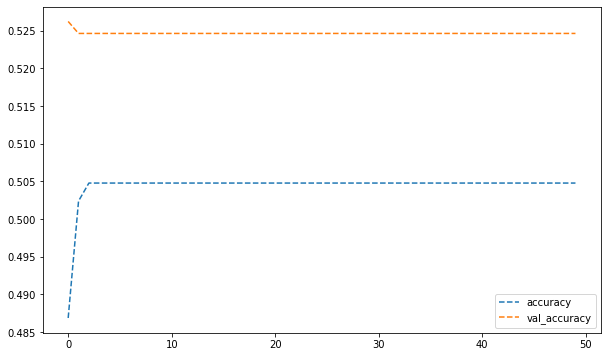

In [ ]:
#-----------------------------------------------------------
# Precisão do classificador LSTM nos dados de treinamento e validação por etapa de treinamento
#-----------------------------------------------------------

res[['accuracy', 'val_accuracy']].plot(figsize=(10, 6), style='--');

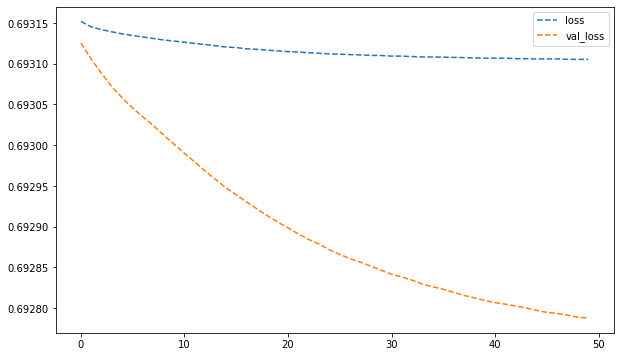

In [ ]:
res[['loss', 'val_loss']].plot(figsize=(10, 6), style='--');

In [ ]:
# '''DADOS DE TESTES'''
'''
#-----------------------------------------------------------
# Avaliar modelo nos dados de Teste (Dados de Testes não utilizados no treinamento)
# A avaliação é um processo durante o desenvolvimento do modelo para 
# verificar se o modelo é o mais adequado para um determinado problema 
# e dados correspondentes. O modelo Keras fornece uma função, avaliar, 
# que faz a avaliação do modelo. Tem três argumentos principais,
# - Dados de teste
# - Rótulo de dados de teste
# - verboso - verdadeiro ou falso
# https://www.tutorialspoint.com/keras/keras_model_evaluation_and_prediction.htm
# https://www.activestate.com/resources/quick-reads/how-to-use-a-model-to-do-predictions-with-keras/ 
#-----------------------------------------------------------
model.evaluate(X_test, y_test)
#model.evaluate(X_test, Y_test)

#-----------------------------------------------------------
# Avaliar modelo nos dados de Teste (Dados de Testes não utilizados no treinamento)
# A previsão é a etapa final e nosso resultado esperado da geração do modelo. 
# Keras fornece um método de previsão para obter a previsão do modelo treinado
# https://www.tutorialspoint.com/keras/keras_model_evaluation_and_prediction.htm
# https://www.activestate.com/resources/quick-reads/how-to-use-a-model-to-do-predictions-with-keras/ 
#-----------------------------------------------------------
pred = model.predict(X_test) 
#pred = model.predict(X_test) 
#print(pred)


#-----------------------------------------------------------
# Interpretação da saida do modelo
# https://datascience.stackexchange.com/questions/65995/tensorflow-sigmoid-activation-function-as-output-layer-value-interpretation
#-----------------------------------------------------------
pred = np.where(model.predict(X_test) > 0.5, 1, 0)
#pred = np.where(model.predict(X_test) > 0.5, 1, 0)

#print(pred.shape)
#print(pred)
pred = pred.reshape(len(pred),1)
#print(pred.shape)
#print(pred)
valores_preditos = [] # predicao
valores_reais = [] # direcao
for predicao, direcao in zip(pred, y_test):
    valores_preditos.append(int(predicao))
    valores_reais.append(int(direcao))
    #print('Predição: {} / Direção: {}'.format(int(predicao), int(direcao)))
    '''

"\n#-----------------------------------------------------------\n# Avaliar modelo nos dados de Teste (Dados de Testes não utilizados no treinamento)\n# A avaliação é um processo durante o desenvolvimento do modelo para \n# verificar se o modelo é o mais adequado para um determinado problema \n# e dados correspondentes. O modelo Keras fornece uma função, avaliar, \n# que faz a avaliação do modelo. Tem três argumentos principais,\n# - Dados de teste\n# - Rótulo de dados de teste\n# - verboso - verdadeiro ou falso\n# https://www.tutorialspoint.com/keras/keras_model_evaluation_and_prediction.htm\n# https://www.activestate.com/resources/quick-reads/how-to-use-a-model-to-do-predictions-with-keras/ \n#-----------------------------------------------------------\nmodel.evaluate(X_test, y_test)\n#model.evaluate(X_test, Y_test)\n\n#-----------------------------------------------------------\n# Avaliar modelo nos dados de Teste (Dados de Testes não utilizados no treinamento)\n# A previsão é a etap

In [ ]:

'''DADOS DE TREINAMENTO'''

#-----------------------------------------------------------
# Avaliar modelo nos dados de Teste (Dados de Testes não utilizados no treinamento)
# A avaliação é um processo durante o desenvolvimento do modelo para 
# verificar se o modelo é o mais adequado para um determinado problema 
# e dados correspondentes. O modelo Keras fornece uma função, avaliar, 
# que faz a avaliação do modelo. Tem três argumentos principais,
# - Dados de teste
# - Rótulo de dados de teste
# - verboso - verdadeiro ou falso
# https://www.tutorialspoint.com/keras/keras_model_evaluation_and_prediction.htm
# https://www.activestate.com/resources/quick-reads/how-to-use-a-model-to-do-predictions-with-keras/ 
#-----------------------------------------------------------
model.evaluate(X_train, y_train)


#-----------------------------------------------------------
# Avaliar modelo nos dados de Teste (Dados de Testes não utilizados no treinamento)
# A previsão é a etapa final e nosso resultado esperado da geração do modelo. 
# Keras fornece um método de previsão para obter a previsão do modelo treinado
# https://www.tutorialspoint.com/keras/keras_model_evaluation_and_prediction.htm
# https://www.activestate.com/resources/quick-reads/how-to-use-a-model-to-do-predictions-with-keras/ 
#-----------------------------------------------------------
pred = model.predict(X_train) 
#pred = model.predict(X_train) 
#print(pred)


#-----------------------------------------------------------
# Interpretação da saida do modelo
# https://datascience.stackexchange.com/questions/65995/tensorflow-sigmoid-activation-function-as-output-layer-value-interpretation
#-----------------------------------------------------------
pred = np.where(model.predict(X_train) > 0.5, 1, 0)

#pred = np.where(model.predict(X_test) > 0.5, 1, 0)


#print(pred.shape)
#pred.flatten()
#print(pred)
pred = pred.reshape(len(pred),1)
#print(pred.shape)
#print(pred)
valores_preditos = [] # predicao
valores_reais = [] # direcao
# for predicao, direcao in zip(pred, Y_test):
for predicao, direcao in zip(pred, y_train):
    valores_preditos.append(int(predicao))
    valores_reais.append(int(direcao))
    #print('Predição: {} / Direção: {}'.format(int(predicao), int(direcao)))



99/99 [==============================] - 0s 2ms/step - loss: 0.6930 - accuracy: 0.5088


In [ ]:
#-----------------------------------------------------------
# Matriz de Confusão
# Fonte: https://medium.com/data-hackers/entendendo-o-que-%C3%A9-matriz-de-confus%C3%A3o-com-python-114e683ec509
#-----------------------------------------------------------

import numpy as np

# 1 para subida, 0 para descida
# print(valores_preditivos)
# print(valores_reais)

def get_confusion_matrix(reais, preditos, labels):
    """
    Uma função que retorna a matriz de confusão para uma classificação binária
    
    Args:
        reais (list): lista de valores reais
        preditos (list): lista de valores preditos pelo modelos
        labels (list): lista de labels a serem avaliados.
            É importante que ela esteja presente, pois usaremos ela para entender
            quem é a classe positiva e quem é a classe negativa
    
    Returns:
        Um numpy.array, no formato:
            numpy.array([
                [ tp, fp ],
                [ fn, tn ]
            ])
    """
    # não implementado
    if len(labels) > 2:
        return None

    if len(reais) != len(preditos):
        return None
    
    # considerando a primeira classe como a positiva, e a segunda a negativa
    true_class = labels[0]
    negative_class = labels[1]

    # valores preditos corretamente
    tp = 0
    tn = 0
    
    # valores preditos incorretamente
    fp = 0
    fn = 0
    
    for (indice, v_real) in enumerate(reais):
        v_predito = preditos[indice]

        # se trata de um valor real da classe positiva
        if v_real == true_class:
            tp += 1 if v_predito == v_real else 0
            fp += 1 if v_predito != v_real else 0
        else:
            tn += 1 if v_predito == v_real else 0
            fn += 1 if v_predito != v_real else 0
    
    return np.array([
        # valores da classe positiva
        [ tp, fp ],
        # valores da classe negativa
        [ fn, tn ]
    ])

get_confusion_matrix(reais=valores_reais, preditos=valores_preditos, labels=[1,0])


#Valores de Teste

                    # Valores preditos
#                      Subida , Descida 
# Valores reais
#                Subida  [355, 435],
#                Descida [412, 498]


# Previu Subida 355 vezes corretamente
# Previu Descida 498 vezes corretamente
# Previu Subida 435 vez incorretamente
# Previu Descida 412 vezes incorretamente 


#Valores de Treinamento

                    # Valores preditos
#                      Subida , Descida 
# Valores reais
#                Subida  [903, 1039],
#                Descida [881, 1123]

# Previu Subida 903 vezes corretamente
# Previu Descida 1123 vezes corretamente
# Previu Subida 1039 vez incorretamente
# Previu Descida 881 vezes incorretamente 

array([[   0, 1543],
       [   0, 1598]])

In [ ]:
# Fonte: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report

from sklearn.metrics import classification_report

print(classification_report(valores_reais, valores_preditos, labels=[0, 1]))

              precision    recall  f1-score   support

           0       0.51      1.00      0.67      1598
           1       0.00      0.00      0.00      1543

    accuracy                           0.51      3141
   macro avg       0.25      0.50      0.34      3141
weighted avg       0.26      0.51      0.34      3141



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
